In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing & Cleaning Data

In [2]:
#Importing all libraries and datasets that are going to be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
preliminary = pd.read_csv('/content/drive/MyDrive/DAC23/DataTrain_Preliminary.csv', sep=';')
prediction = pd.read_csv('/content/drive/MyDrive/DAC23/Data_Prediction.csv', sep=';')

In [3]:
prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12479 entries, 0 to 12478
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           12479 non-null  int64  
 1   duration                     12479 non-null  int64  
 2   protocol_type                12479 non-null  object 
 3   service                      12479 non-null  object 
 4   flag                         12479 non-null  object 
 5   src_bytes                    12479 non-null  int64  
 6   dst_bytes                    12479 non-null  int64  
 7   land                         12479 non-null  int64  
 8   wrong_fragment               12479 non-null  int64  
 9   urgent                       12479 non-null  int64  
 10  hot                          12479 non-null  int64  
 11  num_failed_logins            12479 non-null  int64  
 12  logged_in                    12479 non-null  int64  
 13  num_compromised 

In [4]:
preliminary

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type_of_attack
0,0,tcp,private,SH,0,0,0,0,0,0,...,1,0.01,0.94,0.95,0,0.95,1,0,0,nmap
1,0,tcp,private,S0,0,0,0,0,0,0,...,5,0.02,0.08,0.00,0,1.00,1,0,0,neptune
2,0,tcp,http,SF,285,3623,0,0,0,0,...,228,1.00,0.00,0.01,*,0.00,0,0,0,normal
3,0,tcp,http,SF,232,584,0,0,0,0,...,255,1.00,0.00,0.17,*,0.00,0,0,0,normal
4,1,tcp,smtp,SF,1080,327,0,0,0,0,...,154,0.58,0.02,0.00,*,0.00,0,0,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112441,0,tcp,http,REJ,0,0,0,0,0,0,...,255,1.00,0.00,0.14,*,0.00,0,*,*,normal
112442,0,tcp,http,SF,309,758,0,0,0,0,...,255,1.00,0.00,0.02,*,0.02,*,0,0,normal
112443,0,tcp,http,SF,363,721,0,0,0,0,...,255,1.00,0.00,0.00,0,0.00,0,0,0,normal
112444,0,tcp,discard,RSTO,0,0,0,0,0,0,...,7,0.03,0.06,0.00,0,0.00,0,1,1,neptune


In [5]:
#Finding the amount of missing values in the preliminary dataset
preliminary.isna().sum()

duration                          0
protocol_type                   668
service                        1020
flag                            853
src_bytes                         0
dst_bytes                         0
land                              0
wrong_fragment                    0
urgent                            0
hot                               0
num_failed_logins                 0
logged_in                         0
num_compromised                   0
root_shell                        0
su_attempted                      0
num_root                          0
num_file_creations                0
num_shells                        0
num_access_files                  0
num_outbound_cmds                 0
is_host_login                     0
is_guest_login                    0
count                             0
srv_count                         0
serror_rate                       0
srv_serror_rate                   0
rerror_rate                       0
srv_rerror_rate             

In [6]:
#Removing every missing value in the preliminary dataset
preliminary = preliminary.dropna()
#Figuring out the mean of the numerical columns
preliminary.describe()

,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_serror_rate
count,108666.000000,108666.000000,108666.000000,108666.000000
mean,530.571291,245.786828,55.357140,137.408281
std,7261.155542,4950.760134,2349.123734,3700.366413
min,0.000000,0.000000,0.000000,0.000000
25%,0.050000,0.000000,0.000000,0.000000
50%,0.500000,0.030000,0.000000,0.000000
75%,1.000000,0.070000,0.060000,1.000000
max,99999.000000,99999.000000,99999.000000,99999.000000


In [7]:
#Making a function to check the total amount of certain values in every column
def count_value(df, value):
    return df.apply(lambda col: (col == value).sum())

In [8]:
#Finding out the total amount of * in the dataframe
count_star = count_value(preliminary, '*')
print("Number of '*' values in each column:")
print(count_star)

Number of '*' values in each column:
duration                         546
protocol_type                      0
service                            0
flag                               0
src_bytes                        789
dst_bytes                        701
land                             168
wrong_fragment                   489
urgent                           300
hot                              892
num_failed_logins                340
logged_in                        170
num_compromised                  324
root_shell                        94
su_attempted                     195
num_root                         234
num_file_creations               241
num_shells                       263
num_access_files                 591
num_outbound_cmds                186
is_host_login                     76
is_guest_login                   319
count                            202
srv_count                        209
serror_rate                     4364
srv_serror_rate                 2442
r

In [9]:
#Finding out the total occurence of 99999 in the dataframe
count_99999 = count_value(preliminary, 99999)
print("Number of '99999' values in each column:")
print(count_99999)

Number of '99999' values in each column:
duration                         0
protocol_type                    0
service                          0
flag                             0
src_bytes                        0
dst_bytes                        0
land                             0
wrong_fragment                   0
urgent                           0
hot                              0
num_failed_logins                0
logged_in                        0
num_compromised                  0
root_shell                       0
su_attempted                     0
num_root                         0
num_file_creations               0
num_shells                       0
num_access_files                 0
num_outbound_cmds                0
is_host_login                    0
is_guest_login                   0
count                            0
srv_count                        0
serror_rate                      0
srv_serror_rate                  0
rerror_rate                      0
srv_rerror_rat

In [10]:
#Converting columns with numerical values from object type into numerical type
object_columns = ['protocol_type', 'service', 'flag', 'type_of_attack']
numeric_columns = preliminary.columns.difference(object_columns)
preliminary[numeric_columns] = preliminary[numeric_columns].apply(pd.to_numeric, errors='coerce')

<ipython-input-10-51cef88f11c3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preliminary[numeric_columns] = preliminary[numeric_columns].apply(pd.to_numeric, errors='coerce')


In [11]:
preliminary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108666 entries, 0 to 112445
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     108120 non-null  float64
 1   protocol_type                108666 non-null  object 
 2   service                      108666 non-null  object 
 3   flag                         108666 non-null  object 
 4   src_bytes                    107877 non-null  float64
 5   dst_bytes                    107965 non-null  float64
 6   land                         108498 non-null  float64
 7   wrong_fragment               108177 non-null  float64
 8   urgent                       108366 non-null  float64
 9   hot                          107774 non-null  float64
 10  num_failed_logins            108326 non-null  float64
 11  logged_in                    108496 non-null  float64
 12  num_compromised              108342 non-null  float64
 13 

In [13]:
#Finding out the outliers of every column that are not object type or filled with "Yes" or "No" values
excluded_columns=['protocol_type', 'service', 'flag', 'type_of_attack','land','logged_in','root_shell','su_attempted','is_host_login','is_guest_login']
z_scores = stats.zscore(preliminary.drop(excluded_columns,axis=1))
outliers_count = ((z_scores > 3) | (z_scores < -3)).sum(axis=0)
print("Outliers count for each column:")
print(outliers_count)

Outliers count for each column:
duration                         0
src_bytes                        0
dst_bytes                        0
wrong_fragment                   0
urgent                           0
hot                              0
num_failed_logins                0
num_compromised                  0
num_root                         0
num_file_creations               0
num_shells                       0
num_access_files                 0
num_outbound_cmds                0
count                            0
srv_count                        0
serror_rate                      0
srv_serror_rate                  0
rerror_rate                      0
srv_rerror_rate                  0
same_srv_rate                    0
diff_srv_rate                    0
srv_diff_host_rate               0
dst_host_count                   0
dst_host_srv_count               0
dst_host_same_srv_rate         576
dst_host_diff_srv_rate         267
dst_host_same_src_port_rate     60
dst_host_srv_diff_host_

In [14]:
#Removing every outlier
rows_with_outliers = ((z_scores > 3) | (z_scores < -3)).any(axis=1)
restored_data = preliminary[excluded_columns]
preliminary = preliminary.loc[~rows_with_outliers]
preliminary.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,107068.000000,1.068250e+05,1.069130e+05,107446.000000,107125.000000,107314.000000,106722.000000,107274.000000,107444.000000,107290.000000,...,107062.000000,107059.000000,107614.000000,107614.000000,107614.000000,75431.000000,107614.000000,102060.000000,96934.000000,102031.000000
mean,629.241090,3.399920e+04,2.203567e+04,116.336560,0.023039,63.364892,0.139756,166.861532,0.387765,71.100904,...,344.103323,167.369647,0.514887,0.082674,0.143166,792.777452,0.292913,0.295140,65.084026,0.111407
std,6373.043847,5.138961e+06,4.364488e+06,3408.825632,0.255428,2516.438408,1.718842,4081.448456,0.487243,2660.656823,...,3998.781287,2286.528264,0.449266,0.187129,0.303319,8868.410881,0.449022,0.456108,2548.522851,0.314637
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,87.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,62.000000,0.480000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.660000e+02,4.940000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.000000,1.000000,1.000000,0.000000,0.000000
max,99999.000000,1.379964e+09,1.309937e+09,99999.000000,3.000000,99999.000000,77.000000,99999.000000,1.000000,99999.000000,...,99999.000000,99999.000000,1.000000,1.000000,1.000000,99999.000000,1.000000,1.000000,99999.000000,1.000000


In [15]:
#Replacing every "*" as a missing value
preliminary.replace('*', np.nan, inplace=True)
preliminary.isna().sum()

duration                         546
protocol_type                      0
service                            0
flag                               0
src_bytes                        789
dst_bytes                        701
land                             168
wrong_fragment                   489
urgent                           300
hot                              892
num_failed_logins                340
logged_in                        170
num_compromised                  324
root_shell                        94
su_attempted                     195
num_root                         234
num_file_creations               241
num_shells                       263
num_access_files                 591
num_outbound_cmds                186
is_host_login                     76
is_guest_login                   319
count                            202
srv_count                        209
serror_rate                     4333
srv_serror_rate                 2410
rerror_rate                     3183
s

In [16]:
#Dropping every missing values in every columns with "Yes" or "No" values
columns_drop_na = ['land','logged_in','root_shell','su_attempted','is_host_login','is_guest_login']
preliminary = preliminary.dropna(subset=columns_drop_na)

In [17]:
preliminary.isna().sum()

duration                         546
protocol_type                      0
service                            0
flag                               0
src_bytes                        789
dst_bytes                        676
land                               0
wrong_fragment                   488
urgent                           300
hot                              867
num_failed_logins                340
logged_in                          0
num_compromised                  324
root_shell                         0
su_attempted                       0
num_root                         234
num_file_creations               237
num_shells                       250
num_access_files                 591
num_outbound_cmds                186
is_host_login                      0
is_guest_login                     0
count                            202
srv_count                        188
serror_rate                     4259
srv_serror_rate                 2394
rerror_rate                     3116
s

In [18]:
count_99999 = count_value(preliminary, 99999)
print("Number of '99999' values in each column:")
print(count_99999)

Number of '99999' values in each column:
duration                       363
protocol_type                    0
service                          0
flag                             0
src_bytes                      185
dst_bytes                       22
land                           106
wrong_fragment                   0
urgent                          68
hot                              0
num_failed_logins              179
logged_in                        0
num_compromised                 76
root_shell                     164
su_attempted                    79
num_root                         0
num_file_creations               0
num_shells                     160
num_access_files                17
num_outbound_cmds                0
is_host_login                    0
is_guest_login                 109
count                          857
srv_count                      644
serror_rate                    103
srv_serror_rate                348
rerror_rate                    506
srv_rerror_rat

In [19]:
#Dropping every row of data with 99999 as one of the values
preliminary = preliminary[~preliminary.isin([99999]).any(axis=1)]

In [21]:
preliminary.isna().sum()

duration                         508
protocol_type                      0
service                            0
flag                               0
src_bytes                        746
dst_bytes                        626
land                               0
wrong_fragment                   488
urgent                           272
hot                              852
num_failed_logins                340
logged_in                          0
num_compromised                  324
root_shell                         0
su_attempted                       0
num_root                         234
num_file_creations               237
num_shells                       219
num_access_files                 565
num_outbound_cmds                167
is_host_login                      0
is_guest_login                     0
count                            202
srv_count                        174
serror_rate                     4124
srv_serror_rate                 2288
rerror_rate                     3047
s

In [22]:
preliminary.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,100613.000000,1.003750e+05,1.004950e+05,101121.000000,100633.000000,100849.000000,100269.000000,100781.000000,101121.000000,100797.000000,...,100569.000000,100650.000000,101121.000000,101121.000000,101121.000000,70429.000000,101121.000000,95856.000000,91070.000000,95883.000000
mean,298.710018,3.566288e+04,2.328462e+04,0.000218,0.021822,0.000079,0.139425,0.000675,0.389603,0.281526,...,183.608428,115.423984,0.515821,0.082790,0.143535,0.007937,0.291358,0.293565,0.092325,0.111949
std,2691.514268,5.301450e+06,4.501690e+06,0.014748,0.248896,0.012596,1.721165,0.031806,0.487663,25.699782,...,98.401940,110.875703,0.449290,0.187423,0.303587,0.088737,0.448306,0.455398,0.289485,0.315305
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,86.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,62.000000,0.490000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.670000e+02,5.010000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.000000,1.000000,1.000000,0.000000,0.000000
max,42908.000000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,3.000000,1.000000,7479.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
#Shapiro - Wilk Test to decide if a column has a normal distribution or not
imputation_plan = {}
shapiroExclude = ['protocol_type','service','flag','type_of_attack']
for col in preliminary.columns:
    if col not in shapiroExclude:
        stat, p_value = shapiro(preliminary[col])
        print(f"Shapiro-Wilk test for {col}: p-value = {p_value:.4f}, {'Normal' if p_value > 0.05 else 'Not Normal'}")

        if p_value > 0.05:  # If normal
            imputation_plan[col] = 'mean'
        else:  # If not normal
            imputation_plan[col] = 'median'
    else:
        print(f"Excluded {col} from the test.")

# Fill missing values with mean if the column distribution is normal or with median if the column distribution is not normal
for col, imputation_method in imputation_plan.items():
    if imputation_method == 'mean':
        preliminary[col].fillna(preliminary[col].mean(), inplace=True)
    elif imputation_method == 'median':
        preliminary[col].fillna(preliminary[col].median(), inplace=True)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk test for duration: p-value = 1.0000, Normal
Excluded protocol_type from the test.
Excluded service from the test.
Excluded flag from the test.
Shapiro-Wilk test for src_bytes: p-value = 1.0000, Normal
Shapiro-Wilk test for dst_bytes: p-value = 1.0000, Normal
Shapiro-Wilk test for land: p-value = 0.0000, Not Normal
Shapiro-Wilk test for wrong_fragment: p-value = 1.0000, Normal
Shapiro-Wilk test for urgent: p-value = 1.0000, Normal
Shapiro-Wilk test for hot: p-value = 1.0000, Normal
Shapiro-Wilk test for num_failed_logins: p-value = 1.0000, Normal
Shapiro-Wilk test for logged_in: p-value = 0.0000, Not Normal
Shapiro-Wilk test for num_compromised: p-value = 1.0000, Normal
Shapiro-Wilk test for root_shell: p-value = 0.0000, Not Normal
Shapiro-Wilk test for su_attempted: p-value = 0.0000, Not Normal
Shapiro-Wilk test for num_root: p-value = 1.0000, Normal
Shapiro-Wilk test for num_file_creations: p-value = 1.0000, Normal
Shapiro-Wilk test for num_shells: p-value = 1.0000, Norma

In [24]:
preliminary

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type_of_attack
0,0.0,tcp,private,SH,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.01,0.94,0.95,0.000000,0.95,1.000000,0.000000,0.000000,nmap
2,0.0,tcp,http,SF,285.0,3623.0,0.0,0.0,0.0,0.0,...,228.0,1.00,0.00,0.01,0.007937,0.00,0.000000,0.000000,0.000000,normal
3,0.0,tcp,http,SF,232.0,584.0,0.0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.17,0.007937,0.00,0.000000,0.000000,0.000000,normal
4,1.0,tcp,smtp,SF,1080.0,327.0,0.0,0.0,0.0,0.0,...,154.0,0.58,0.02,0.00,0.007937,0.00,0.000000,0.000000,0.000000,normal
5,0.0,tcp,discard,S0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.0,0.07,0.05,0.00,0.000000,1.00,1.000000,0.000000,0.000000,neptune
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112441,0.0,tcp,http,REJ,0.0,0.0,0.0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.14,0.007937,0.00,0.000000,0.092325,0.111949,normal
112442,0.0,tcp,http,SF,309.0,758.0,0.0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.02,0.007937,0.02,0.293565,0.000000,0.000000,normal
112443,0.0,tcp,http,SF,363.0,721.0,0.0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,normal
112444,0.0,tcp,discard,RSTO,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.03,0.06,0.00,0.000000,0.00,0.000000,1.000000,1.000000,neptune


In [25]:
preliminary.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,101121.000000,1.011210e+05,1.011210e+05,101121.000000,101121.000000,101121.000000,101121.000000,101121.000000,101121.000000,101121.000000,...,101121.000000,101121.000000,101121.000000,101121.000000,101121.000000,101121.000000,101121.000000,101121.000000,101121.000000,101121.000000
mean,298.710018,3.566288e+04,2.328462e+04,0.000218,0.021822,0.000079,0.139425,0.000675,0.389603,0.281526,...,183.608428,115.423984,0.515821,0.082790,0.143535,0.007937,0.291358,0.293565,0.092325,0.111949
std,2684.745030,5.281858e+06,4.487734e+06,0.014748,0.248295,0.012579,1.713899,0.031753,0.487663,25.658576,...,98.132991,110.617181,0.449290,0.187423,0.303587,0.074055,0.448306,0.443383,0.274722,0.307030
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,87.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.490000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.750000e+02,5.510000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.007937,1.000000,1.000000,0.000000,0.000000
max,42908.000000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,3.000000,1.000000,7479.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# RANDOM FOREST

In [26]:
#Preparing the dataset to train the model
xRF = preliminary.drop(["type_of_attack","service","flag"], axis=1)
yRF = preliminary["type_of_attack"]

In [27]:
#Splitting the dataset into two parts, training and testing
xRF_train, xRF_test, yRF_train, yRF_test = train_test_split(xRF, yRF, test_size=0.2, random_state=42)

In [28]:
#Giving numerical value for every values in "protocol_type"
trainXRF = pd.get_dummies(xRF_train, columns=["protocol_type"])
testXRF = pd.get_dummies(xRF_test, columns=["protocol_type"])

In [29]:
#Training the Random Forest Classifier Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(trainXRF,yRF_train)

RandomForestClassifier(random_state=42)

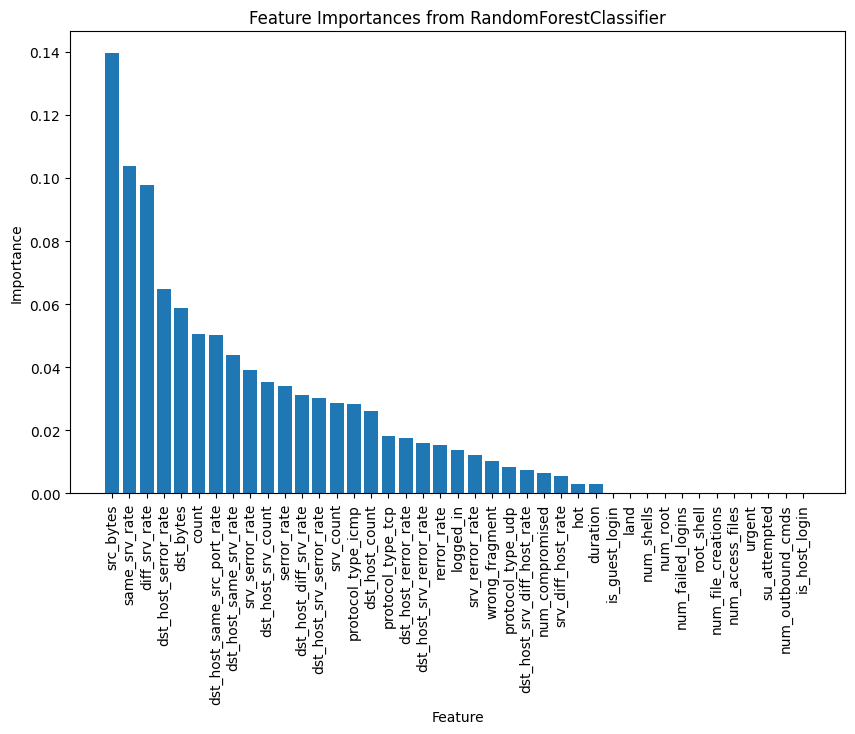

In [30]:
# Get feature importances
feature_importances = model.feature_importances_

# Get the indices of features sorted by importance
sorted_indices = np.argsort(feature_importances)[::-1]

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(trainXRF.shape[1]), feature_importances[sorted_indices], align="center")
plt.xticks(range(trainXRF.shape[1]), trainXRF.columns[sorted_indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances from RandomForestClassifier")
plt.show()

In [31]:
#Predicting the "type_of_attack" column for the testing data
y_predRF=model.predict(testXRF)

In [32]:
#Accuracy and result of the classification model
accuracy = accuracy_score(yRF_test, y_predRF)
classification_report_result = classification_report(yRF_test, y_predRF,zero_division=1)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report_result)

Accuracy: 0.9955006180469715
Classification Report:
                          precision    recall  f1-score   support

Denial of Service Attack       1.00      0.99      0.99       324
                 ipsweep       0.92      0.96      0.94       603
                 neptune       1.00      1.00      1.00      6677
                    nmap       0.87      0.77      0.81       205
                  normal       1.00      1.00      1.00     10938
               portsweep       1.00      0.99      0.99       509
                   satan       1.00      0.99      1.00       543
                   smurf       1.00      1.00      1.00       426

                accuracy                           1.00     20225
               macro avg       0.97      0.96      0.97     20225
            weighted avg       1.00      1.00      1.00     20225



In [33]:
#Preparing the prediction dataset
X_predRF = prediction.drop(["id","service","flag"],axis=1)
predXRF = pd.get_dummies(X_predRF, columns=["protocol_type"])

In [34]:
#Predicting the type of attack of every rows in the prediction dataset
predRF = model.predict(predXRF)

In [35]:
answerRF = prediction

In [36]:
#Inserting the values of "type_of_attack" into the prediction dataset
answerRF["type_of_attack"] = predRF

In [37]:
answerRF

,id,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type_of_attack
0,1,1,tcp,smtp,SF,2397,328,0,0,0,...,182,0.68,0.02,0.01,0.01,0.0,0.0,0.0,0.0,normal
1,2,990,udp,other,SF,145,105,0,0,0,...,1,0.00,0.64,0.94,0.00,0.0,0.0,0.0,0.0,normal
2,3,0,icmp,ecr_i,SF,1032,0,0,0,0,...,23,0.09,0.02,0.09,0.00,0.0,0.0,0.0,0.0,smurf
3,4,0,icmp,eco_i,SF,8,0,0,0,0,...,85,1.00,0.00,1.00,0.51,0.0,0.0,0.0,0.0,ipsweep
4,5,0,udp,domain_u,SF,44,132,0,0,0,...,101,0.40,0.01,0.38,0.00,0.0,0.0,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12474,12475,0,tcp,http,SF,320,1673,0,0,0,...,255,1.00,0.00,0.01,0.06,0.0,0.0,0.0,0.0,normal
12475,12476,21410,tcp,private,RSTR,1,0,0,0,0,...,2,0.01,0.69,1.00,0.00,0.0,0.0,1.0,1.0,portsweep
12476,12477,1,tcp,smtp,SF,743,371,0,0,0,...,207,1.00,0.00,0.17,0.01,0.0,0.0,0.0,0.0,normal
12477,12478,0,icmp,eco_i,SF,8,0,0,0,0,...,168,1.00,0.00,1.00,0.25,0.0,0.0,0.0,0.0,nmap


In [38]:
preliminary

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type_of_attack
0,0.0,tcp,private,SH,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.01,0.94,0.95,0.000000,0.95,1.000000,0.000000,0.000000,nmap
2,0.0,tcp,http,SF,285.0,3623.0,0.0,0.0,0.0,0.0,...,228.0,1.00,0.00,0.01,0.007937,0.00,0.000000,0.000000,0.000000,normal
3,0.0,tcp,http,SF,232.0,584.0,0.0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.17,0.007937,0.00,0.000000,0.000000,0.000000,normal
4,1.0,tcp,smtp,SF,1080.0,327.0,0.0,0.0,0.0,0.0,...,154.0,0.58,0.02,0.00,0.007937,0.00,0.000000,0.000000,0.000000,normal
5,0.0,tcp,discard,S0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.0,0.07,0.05,0.00,0.000000,1.00,1.000000,0.000000,0.000000,neptune
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112441,0.0,tcp,http,REJ,0.0,0.0,0.0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.14,0.007937,0.00,0.000000,0.092325,0.111949,normal
112442,0.0,tcp,http,SF,309.0,758.0,0.0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.02,0.007937,0.02,0.293565,0.000000,0.000000,normal
112443,0.0,tcp,http,SF,363.0,721.0,0.0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,normal
112444,0.0,tcp,discard,RSTO,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.03,0.06,0.00,0.000000,0.00,0.000000,1.000000,1.000000,neptune


In [39]:
answerRF["type_of_attack"].value_counts()

normal                      6813
neptune                     4073
satan                        382
ipsweep                      368
smurf                        251
portsweep                    243
Denial of Service Attack     201
nmap                         148
Name: type_of_attack, dtype: int64

In [40]:
preliminary["type_of_attack"].value_counts()

normal                      54215
neptune                     33934
ipsweep                      2890
satan                        2769
portsweep                    2492
smurf                        2134
Denial of Service Attack     1579
nmap                         1108
Name: type_of_attack, dtype: int64

In [41]:
predictionValueCount = answerRF["type_of_attack"].value_counts()
predictionRatio = predictionValueCount / predictionValueCount.sum()
print("Ratio of each type_of_attack in the prediction dataset:")
print(predictionRatio)

Ratio of each type_of_attack in the prediction dataset:
normal                      0.545957
neptune                     0.326388
satan                       0.030611
ipsweep                     0.029490
smurf                       0.020114
portsweep                   0.019473
Denial of Service Attack    0.016107
nmap                        0.011860
Name: type_of_attack, dtype: float64


In [42]:
preliminaryValueCount = preliminary["type_of_attack"].value_counts()
preliminaryRatio = preliminaryValueCount / preliminaryValueCount.sum()
print("Ratio of each type_of_attack in the preliminary dataset:")
print(preliminaryRatio)

Ratio of each type_of_attack in the preliminary dataset:
normal                      0.536140
neptune                     0.335578
ipsweep                     0.028580
satan                       0.027383
portsweep                   0.024644
smurf                       0.021103
Denial of Service Attack    0.015615
nmap                        0.010957
Name: type_of_attack, dtype: float64


In [45]:
#Creating a dataframe to compare the ratio of the results
comparison_df = pd.DataFrame({
    'Preliminary': preliminaryRatio,
    'Prediction': predictionRatio
})
comparison_df = comparison_df.sort_values(by='Preliminary', ascending=False)

<Figure size 1000x600 with 0 Axes>

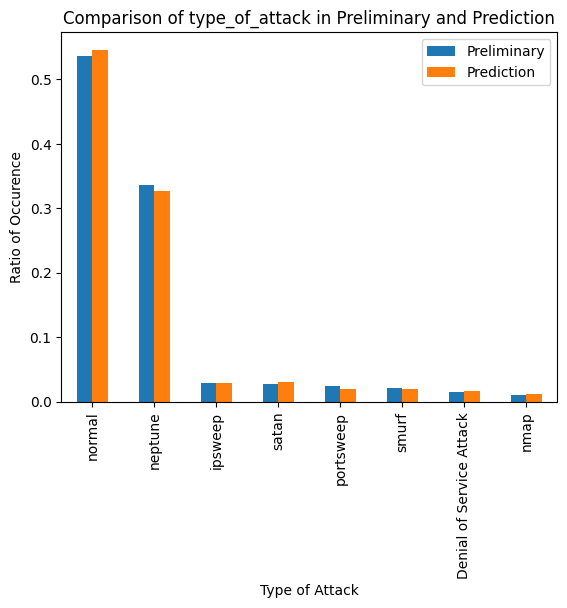

In [47]:
plt.figure(figsize=(10, 6))
comparison_df.plot(kind='bar', stacked=False)
plt.title('Comparison of type_of_attack in Preliminary and Prediction')
plt.xlabel('Type of Attack')
plt.ylabel('Ratio of Occurence')
plt.show()